# Programming assignment 11: Gaussian Mixture Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from scipy.stats import multivariate_normal

## Your task

In this homework sheet we will implement Expectation-Maximization algorithm for learning & inference in a Gaussian mixture model.

We will use the [dataset](http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat) containing information about eruptions of a geyser called "Old Faithful". The dataset in suitable format can be downloaded from Piazza.

As usual, your task is to fill out the missing code, run the notebook, convert it to PDF and attach it you your HW solution.

## Generate and visualize the data

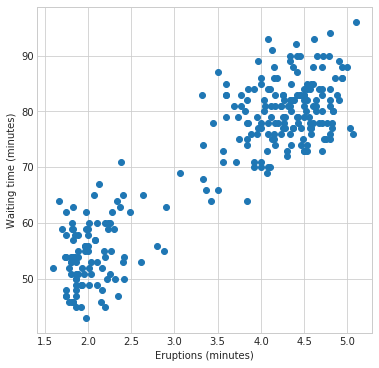

In [2]:
X = np.loadtxt('faithful.txt')
plt.figure(figsize=[6, 6])
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Eruptions (minutes)')
plt.ylabel('Waiting time (minutes)')
plt.show()

## Task 1: Normalize the data

Notice, how the values on two axes are on very different scales. This might cause problems for our clustering algorithm. 

Normalize the data, such that it lies in the range $[0, 1]$ along each dimension (each column of X).

In [3]:
def normalize_data(X):
    """Normalize data such that it lies in range [0, 1] along every dimension.
    
    Parameters
    ----------
    X : np.array, shape [N, D]
        Data matrix, each row represents a sample.
        
    Returns
    -------
    X_norm : np.array, shape [N, D]
        Normalized data matrix. 
    """
    N = len(X[:,0])
    D = len(X[0,:])
    X_norm = (X-np.min(X,axis=0))/(np.max(X,axis=0) - np.min(X,axis=0))
    return X_norm

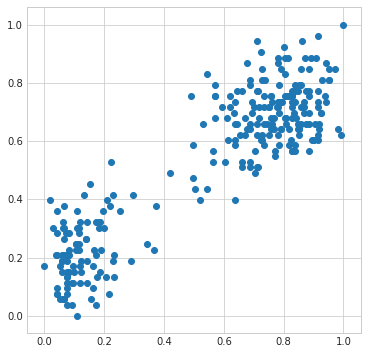

In [4]:
plt.figure(figsize=[6, 6])
X_norm = normalize_data(X)
plt.scatter(X_norm[:, 0], X_norm[:, 1]);

## Task 2: Compute the log-likelihood of GMM

Here and in some other places, you might want to use the function `multivariate_normal.pdf` from the `scipy.stats` package.

In [5]:
def gmm_log_likelihood(X, means, covs, mixing_coefs):
    """Compute the log-likelihood of the data under current parameters setting.
    
    Parameters
    ----------
    X : np.array, shape [N, D]
        Data matrix with samples as rows.
    means : np.array, shape [K, D]
        Means of the GMM (\mu in lecture notes).
    covs : np.array, shape [K, D, D]
        Covariance matrices of the GMM (\Sigma in lecuture notes).
    mixing_coefs : np.array, shape [K]
        Mixing proportions of the GMM (\pi in lecture notes).
        
    Returns
    -------
    log_likelihood : float
        log p(X | \mu, \Sigma, \pi) - Log-likelihood of the data under the given GMM.
    """
    
    log_likelihood = 0
    K = len(mixing_coefs)
    for i in range(np.size(X, 0)):
        log_likelihood += np.log(sum( \
            [mixing_coefs[k] * \
             multivariate_normal.pdf(X[i, :], means[k, :], covs[k, :, :]) for k in range(K)]))

    return log_likelihood

## Task 3: E step

In [6]:
def e_step(X, means, covs, mixing_coefs):
    """Perform the E step.
    
    Compute the responsibilities.
    
    Parameters
    ----------
    X : np.array, shape [N, D]
        Data matrix with samples as rows.
    means : np.array, shape [K, D]
        Means of the GMM (\mu in lecture notes).
    covs : np.array, shape [K, D, D]
        Covariance matrices of the GMM (\Sigma in lecuture notes).
    mixing_coefs : np.array, shape [K]
        Mixing proportions of the GMM (\pi in lecture notes).
    
    Returns
    -------
    responsibilities : np.array, shape [N, K]
        Cluster responsibilities for the given data.
    """
    responsibilities = np.zeros([np.size(X, 0), len(mixing_coefs)])
    N = np.size(X, 0)
    K = len(mixing_coefs)

    for n in range(N):
        denominator = sum([mixing_coefs[k] * multivariate_normal.pdf( \
            X[n, :], means[k, :], covs[k, :, :]) \
                           for k in range(K)])

        responsibilities[n, :] = [mixing_coefs[k] * multivariate_normal.pdf( \
            X[n, :], means[k, :], covs[k, :, :]) \
                                  for k in range(K)] / denominator

    return responsibilities

## Task 4: M step

In [7]:
def m_step(X, responsibilities):
    """Update the parameters \theta of the GMM to maximize E[log p(X, Z | \theta)].
    
    Parameters
    ----------
    X : np.array, shape [N, D]
        Data matrix with samples as rows.
    responsibilities : np.array, shape [N, K]
        Cluster responsibilities for the given data.
    
    Returns
    -------
    means : np.array, shape [K, D]
        Means of the GMM (\mu in lecture notes).
    covs : np.array, shape [K, D, D]
        Covariance matrices of the GMM (\Sigma in lecuture notes).
    mixing_coefs : np.array, shape [K]
        Mixing proportions of the GMM (\pi in lecture notes).
    
    """
    N = np.size(responsibilities, 0)
    K = np.size(responsibilities, 1)
    D = np.size(X, 1)

    covs = np.zeros([K, D, D])

    N_k = np.array([sum(responsibilities[:, k]) for k in range(K)])
    mixing_coefs = N_k[:] / N
    # assign \mu_k
    means = np.array([1 / N_k[k] * sum([responsibilities[n, k] * X[n, :] for \
               n in range(N)]) for k in range(K)])
    # assign covs_k
    for k in range(K):
        covs[k, :, :] = 1 / N_k[k] * np.sum([responsibilities[n, k] * \
                np.outer((X[n, :] - means[k, :]), (X[n, :] - means[k, :])) for \
                n in range(N)], axis=0)

    return means, covs, mixing_coefs

## Visualize the result (nothing to do here)

In [8]:
def plot_gmm_2d(X, responsibilities, means, covs, mixing_coefs):
    """Visualize a mixture of 2 bivariate Gaussians.
    
    This is badly written code. Please don't write code like this.
    """
    plt.figure(figsize=[6, 6])
    palette = np.array(sns.color_palette('colorblind', n_colors=3))[[0, 2]]
    colors = responsibilities.dot(palette)
    # Plot the samples colored according to p(z|x)
    plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.5)
    # Plot locations of the means
    for ix, m in enumerate(means):
        plt.scatter(m[0], m[1], s=300, marker='X', c=palette[ix],
                    edgecolors='k', linewidths=1,)
    # Plot contours of the Gaussian
    x = np.linspace(0, 1, 50)
    y = np.linspace(0, 1, 50)
    xx, yy = np.meshgrid(x, y)
    for k in range(len(mixing_coefs)):
        zz = mlab.bivariate_normal(xx, yy, np.sqrt(covs[k][0, 0]),
                                   np.sqrt(covs[k][1, 1]), 
                                   means[k][0], means[k][1], covs[k][0, 1])
        plt.contour(xx, yy, zz, 2, colors='k')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

## Run the EM algorithm

At initialization: log-likelihood = -382.70551524206564


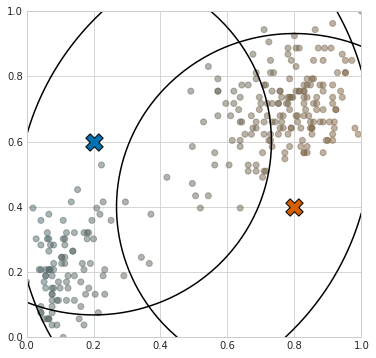

Iteration 0: log-likelihood = 131.29, improvement = 513.99


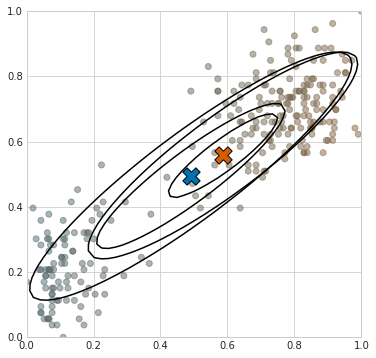

Iteration 1: log-likelihood = 131.48, improvement = 0.19


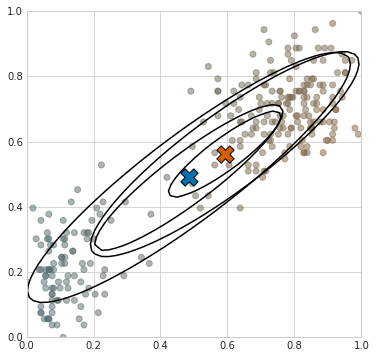

Iteration 2: log-likelihood = 131.75, improvement = 0.27


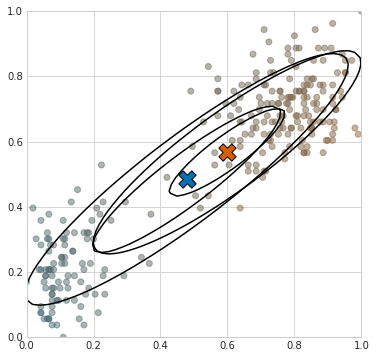

Iteration 3: log-likelihood = 132.15, improvement = 0.40


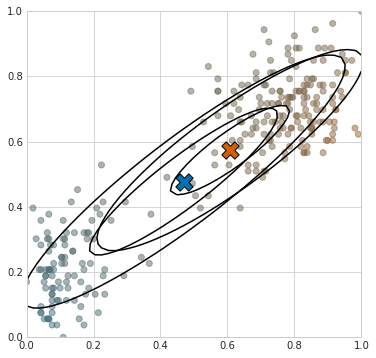

Iteration 4: log-likelihood = 132.77, improvement = 0.62


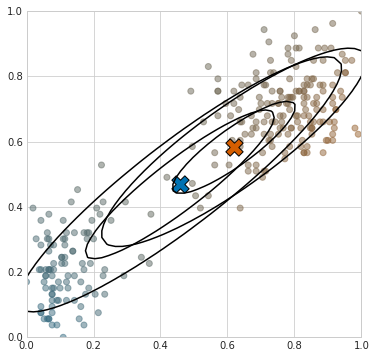

Iteration 5: log-likelihood = 133.81, improvement = 1.04


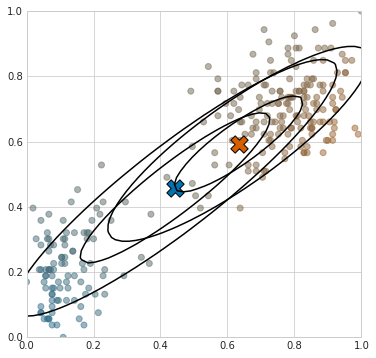

Iteration 6: log-likelihood = 135.74, improvement = 1.93


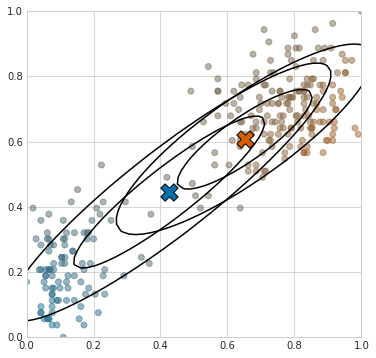

Iteration 7: log-likelihood = 139.88, improvement = 4.14


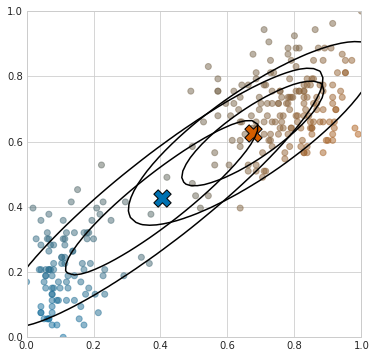

Iteration 8: log-likelihood = 150.67, improvement = 10.79


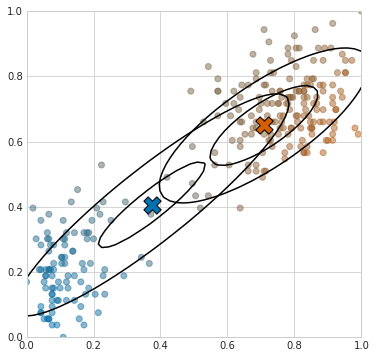

Iteration 9: log-likelihood = 181.12, improvement = 30.45


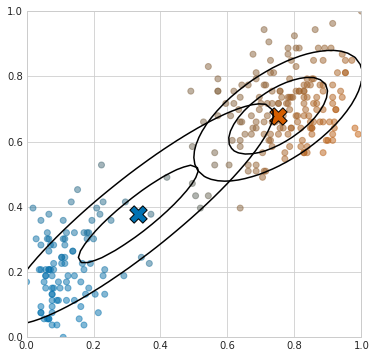

Iteration 10: log-likelihood = 220.93, improvement = 39.81


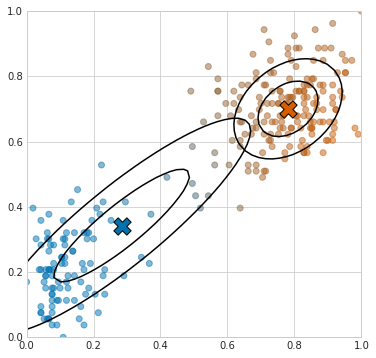

Iteration 11: log-likelihood = 234.06, improvement = 13.14


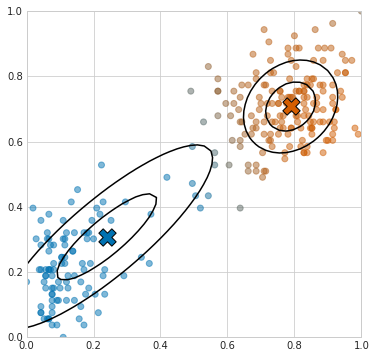

Iteration 12: log-likelihood = 244.83, improvement = 10.77


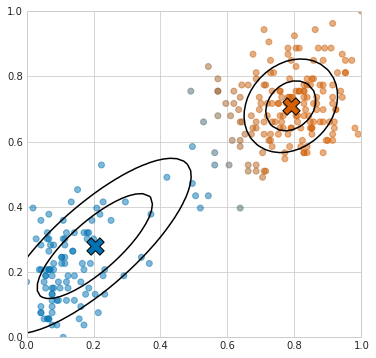

Iteration 13: log-likelihood = 258.67, improvement = 13.84


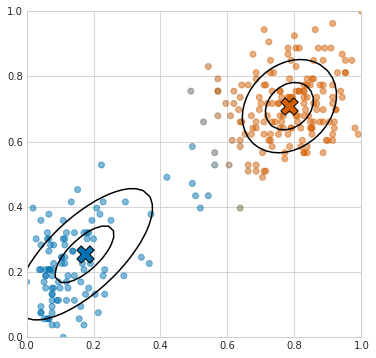

Iteration 14: log-likelihood = 272.91, improvement = 14.23


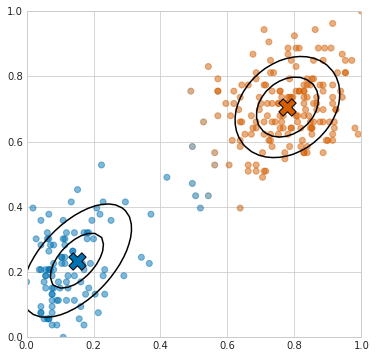

Iteration 15: log-likelihood = 284.29, improvement = 11.38


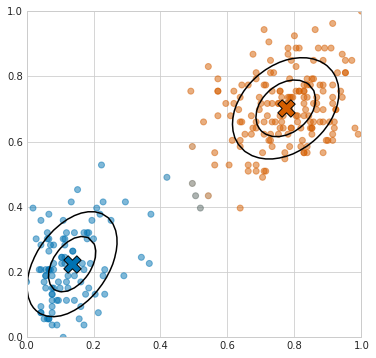

Iteration 16: log-likelihood = 289.94, improvement = 5.65


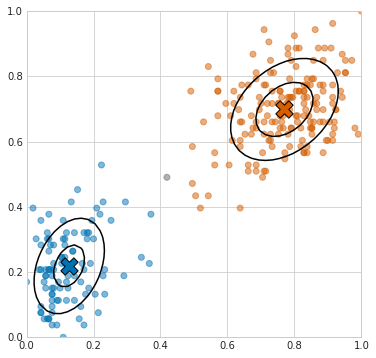

Iteration 17: log-likelihood = 290.39, improvement = 0.45


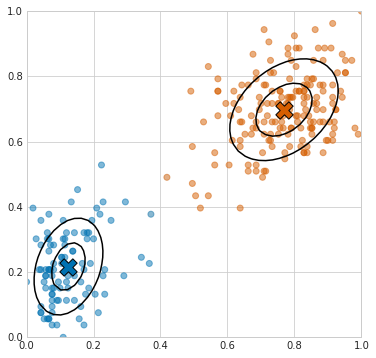

Iteration 18: log-likelihood = 290.41, improvement = 0.01


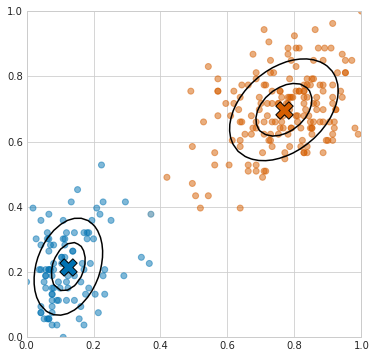

Iteration 19: log-likelihood = 290.41, improvement = 0.00


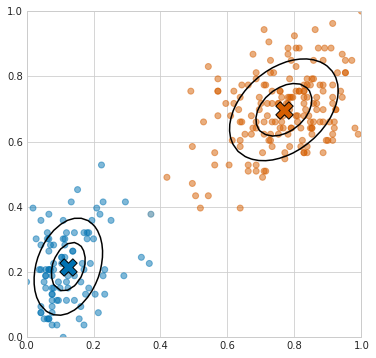

In [9]:
X_norm = normalize_data(X)
max_iters = 20

# Initialize the parameters
means = np.array([[0.2, 0.6], [0.8, 0.4]])
covs = np.array([0.5 * np.eye(2), 0.5 * np.eye(2)])
mixing_coefs = np.array([0.5, 0.5])

old_log_likelihood = gmm_log_likelihood(X_norm, means, covs, mixing_coefs)
responsibilities = e_step(X_norm, means, covs, mixing_coefs)
print('At initialization: log-likelihood = {0}'
      .format(old_log_likelihood))
plot_gmm_2d(X_norm, responsibilities, means, covs, mixing_coefs)

# Perform the EM iteration
for i in range(max_iters):
    responsibilities = e_step(X_norm, means, covs, mixing_coefs)
    means, covs, mixing_coefs = m_step(X_norm, responsibilities)
    new_log_likelihood = gmm_log_likelihood(X_norm, means, covs, mixing_coefs)
    # Report & visualize the optimization progress
    print('Iteration {0}: log-likelihood = {1:.2f}, improvement = {2:.2f}'
          .format(i, new_log_likelihood, new_log_likelihood - old_log_likelihood))
    old_log_likelihood = new_log_likelihood
    plot_gmm_2d(X_norm, responsibilities, means, covs, mixing_coefs)